# Energy Prediction

In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error


## Read Data and Correct errors

In [397]:
df = pd.read_csv("../datsets/dataset1/archive/HomeC.csv", delimiter = ',')
 

#Dropped last line (null)
df.drop(df.tail(1).index,inplace=True)


#Time is wrong, data was recorded minutely
time_index = pd.date_range('2016-01-01 05:00', periods=len(df),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

#Retirar [kW]
df.columns = [col.replace(' [kW]', '') for col in df.columns]


#Somar colunas 
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
df = df.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)
df = df.drop(['Furnace 1','Furnace 2'], axis=1)

#this column is the same as use
df = df.drop(columns=['House overall'])

#useless
df = df.drop(columns=['summary'])
df = df.drop(columns=['icon'])


df



/home/joaonps/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-16 03:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-16 03:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-16 03:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-16 03:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [398]:
#df.to_csv('../datsets/dataset1/archive/HomeC.csv', index=False)  #save

In [399]:
print(df['cloudCover'].unique())

#replace missing values with the next valid observation 
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 

#change to floar
df['cloudCover'] = df['cloudCover'].astype('float')

df['cloudCover'].unique()

['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.33 0.6 0.68 0.66 0.45 0.34 0.52 0.67 0.48 0.49 0.39 0.37
 0.62 0.36 0.79 0.61 0.38 0.42 0.53 0.63 0.44 0.54 0.32 0.56 0.58 0.72
 0.57 0.73 0.71 0.64 0.59]


array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [400]:
df.isnull().sum() #check for null values

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 05:00:00 to 2016-12-16 03:29:00
Freq: T
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   Dishwasher           503910 non-null  float64
 3   Home office          503910 non-null  float64
 4   Fridge               503910 non-null  float64
 5   Wine cellar          503910 non-null  float64
 6   Garage door          503910 non-null  float64
 7   Barn                 503910 non-null  float64
 8   Well                 503910 non-null  float64
 9   Microwave            503910 non-null  float64
 10  Living room          503910 non-null  float64
 11  Solar                503910 non-null  float64
 12  temperature          503910 non-null  float64
 13  humidity             503910 non-null  float64
 14  visibility           50391

## Visualisations

<AxesSubplot:>

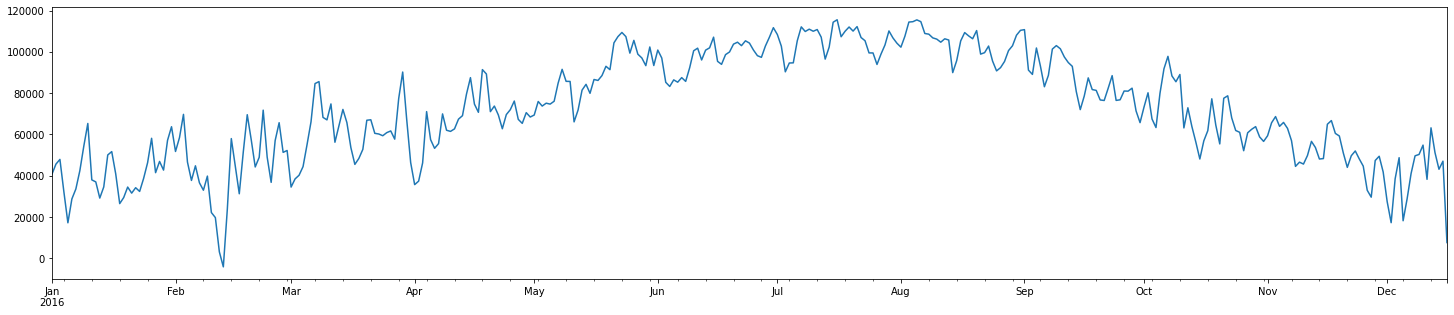

In [401]:

df['temperature'].resample(rule='D').sum().plot(figsize=(25,5))    #group by day
#dataset.groupby(dataset.index.hour).mean()['Microwave'].plot(xticks=np.arange(24)).set(xlabel='Daily Hours', ylabel='Microwave Usage (kW)')

<AxesSubplot:>

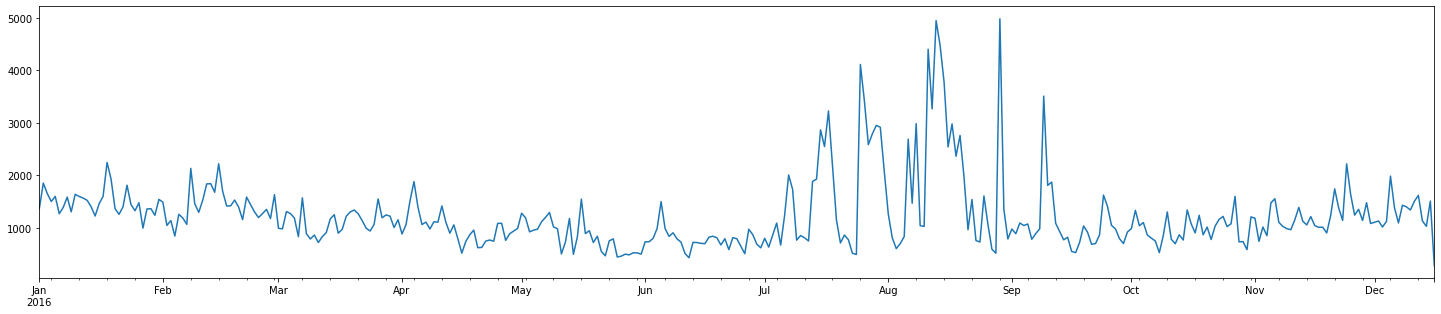

In [402]:
df['use'].resample(rule='D').sum().plot(figsize=(25,5))         #group by day


## Data Treatment

In [403]:
#GROUP DATA PER HOUR INTERVAL

#data  is in KwH, basta fazer a media
'''
d = {'time': 'last', 'humidity': 'last', 'temperature': 'last', 'precipIntensity' : 'last'}
d = {
    "use" : 'sum',
    "gen" : 'sum',
    "Dishwasher" : 'sum',
    "Home office" : 'sum',
    "Fridge" : 'sum',
    "Wine cellar" : 'sum',
    "Garage door" : 'sum',
    "Barn" : 'sum',
    "Well" : 'sum',
    "Microwave" : 'sum',
    "Living room" : 'sum',
    "Solar" : 'sum',
    "temperature" : 'mean',
    "humidity" : 'mean',
    "visibility" : 'mean',
    "apparentTemperature" : 'mean',
    "pressure" : 'mean',
    "windSpeed" : 'mean',
    "cloudCover" : 'mean',
    "windBearing" : 'mean',
    "precipIntensity" : 'mean',
    "dewPoint" : 'mean',
    "precipProbability" : 'mean',
    "Furnace" : 'sum',
    "Kitchen" : 'sum'
}

df = df.groupby(pd.Grouper(freq='H')).agg(d)'''

df = df.resample('H').mean()


#DROP LAST LINE (INCOMPLETE HOUR)
df.drop(df.tail(1).index,inplace=True)

df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 05:00:00,1.044130,0.003307,0.000064,0.241814,0.037861,0.063351,0.013046,0.038881,0.001042,0.021652,...,29.264667,1016.888000,9.150333,0.750000,282.100000,0.000000,24.383333,0.000,0.393188,0.000821
2016-01-01 06:00:00,0.918167,0.003422,0.000099,0.043294,0.075522,0.112942,0.012836,0.039181,0.001021,0.004216,...,29.364667,1016.232000,8.284000,0.750000,284.733333,0.000000,23.866000,0.000,0.456708,0.000749
2016-01-01 07:00:00,0.714736,0.003448,0.000043,0.043416,0.059486,0.007184,0.013299,0.034439,0.001014,0.004246,...,29.034000,1015.989000,7.927000,0.750000,279.400000,0.000000,23.469000,0.000,0.372170,0.000726
2016-01-01 08:00:00,0.960013,0.003447,0.000138,0.065014,0.060412,0.007045,0.012925,0.034195,0.001016,0.004274,...,30.395333,1016.042000,5.684667,0.750000,265.000000,0.000000,24.202667,0.000,0.616370,0.000806
2016-01-01 09:00:00,0.639836,0.003439,0.000060,0.043392,0.035106,0.007143,0.013220,0.031830,0.001014,0.004258,...,29.673333,1015.815000,6.975000,0.625000,265.500000,0.000000,24.423333,0.000,0.343842,0.000796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:00:00,1.210261,0.004140,0.000071,0.041784,0.033194,0.008212,0.012851,0.031983,0.040707,0.003049,...,29.789833,1006.190000,12.677667,0.216667,256.716667,0.000000,20.654667,0.000,0.830258,0.000735
2016-12-15 23:00:00,1.096999,0.004137,0.000075,0.041853,0.044236,0.008119,0.012814,0.032249,0.000992,0.003084,...,29.392667,1012.775333,11.183333,0.816000,189.666667,0.000373,28.414667,0.008,0.772467,0.000732
2016-12-16 00:00:00,1.276585,0.004109,0.000059,0.041711,0.050492,0.105546,0.012526,0.030902,0.040522,0.003001,...,29.813667,1012.628500,11.969500,0.310000,197.633333,0.004313,29.379167,0.182,0.796006,0.000639
2016-12-16 01:00:00,1.260231,0.004141,0.000100,0.041921,0.049140,0.123134,0.012743,0.031992,0.000999,0.003104,...,28.988000,1012.129667,10.720667,0.310000,197.900000,0.010600,30.864333,0.510,0.823418,0.000766


In [404]:

df['month'] = df.index.month
df['weekday'] = df.index.day
df['hour'] = df.index.hour
#df=pd.get_dummies(df)


#Intruduce consumpt in the last 5 hours
for step in range(1,6):
    col_name = "use" + str(step) + "ago"
    df[col_name] = df["use"].shift(step, axis = 0)
    
df = df.iloc[5:]   #drop 5 first rows since there is no data relating last 5 hours

df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,Furnace,Kitchen,month,weekday,hour,use1ago,use2ago,use3ago,use4ago,use5ago
2016-01-01 10:00:00,1.219416,0.003426,0.000072,0.043238,0.051328,0.007190,0.013058,0.034142,0.001010,0.004251,...,0.860671,0.000749,1,1,10,0.639836,0.960013,0.714736,0.918167,1.044130
2016-01-01 11:00:00,0.798747,0.003422,0.000084,0.043268,0.059360,0.007114,0.013117,0.031762,0.001011,0.004212,...,0.455188,0.000789,1,1,11,1.219416,0.639836,0.960013,0.714736,0.918167
2016-01-01 12:00:00,0.537055,0.003419,0.000087,0.042833,0.048724,0.006981,0.012914,0.031127,0.001013,0.004255,...,0.270219,0.000786,1,1,12,0.798747,1.219416,0.639836,0.960013,0.714736
2016-01-01 13:00:00,0.358377,0.006484,0.000006,0.041778,0.044278,0.007071,0.013098,0.030184,0.001011,0.004206,...,0.084606,0.000677,1,1,13,0.537055,0.798747,1.219416,0.639836,0.960013
2016-01-01 14:00:00,0.756720,0.114866,0.000064,0.041722,0.026720,0.006971,0.012862,0.028649,0.042320,0.013937,...,0.231673,0.081184,1,1,14,0.358377,0.537055,0.798747,1.219416,0.639836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:00:00,1.210261,0.004140,0.000071,0.041784,0.033194,0.008212,0.012851,0.031983,0.040707,0.003049,...,0.830258,0.000735,12,15,22,1.199148,0.776981,0.444340,0.592600,0.550936
2016-12-15 23:00:00,1.096999,0.004137,0.000075,0.041853,0.044236,0.008119,0.012814,0.032249,0.000992,0.003084,...,0.772467,0.000732,12,15,23,1.210261,1.199148,0.776981,0.444340,0.592600
2016-12-16 00:00:00,1.276585,0.004109,0.000059,0.041711,0.050492,0.105546,0.012526,0.030902,0.040522,0.003001,...,0.796006,0.000639,12,16,0,1.096999,1.210261,1.199148,0.776981,0.444340
2016-12-16 01:00:00,1.260231,0.004141,0.000100,0.041921,0.049140,0.123134,0.012743,0.031992,0.000999,0.003104,...,0.823418,0.000766,12,16,1,1.276585,1.096999,1.210261,1.199148,0.776981


In [405]:
#SELECT COLUMNS

use = df["use"]


xnames = list(df.columns)
xnames.remove('use')             #this is y
xnames.remove('gen')             #generation
xnames.remove('Solar')           #solar generation


features = df[xnames]


'''
scores = r_regression(features, use)
scores = sorted([(features.columns[i], scores[i]) for i in range(len(scores))], key=lambda x: x[1], reverse=True)
scores
'''

'\nscores = r_regression(features, use)\nscores = sorted([(features.columns[i], scores[i]) for i in range(len(scores))], key=lambda x: x[1], reverse=True)\nscores\n'

In [406]:
features.drop(features.tail(1).index,inplace=True) #drop last row
use = use.iloc[1:]   #drop first row


print(features.shape)
print(use.shape)

(8392, 30)
(8392,)


/home/joaonps/.local/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Training

In [413]:
x = features.values
y = use.values.reshape(-1, 1)

#ultimas 720 horas, 1 mes
x = x[-4000:]
y = y[-4000:]


In [414]:
st_x = StandardScaler()
st_y = StandardScaler()
X = st_x.fit_transform(x)
Y = st_y.fit_transform(y)


In [417]:
#_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=300, shuffle=False)

x_train = X[:-300]
x_test = X[-300:]
y_train = Y[]:-300]
y_test = Y[-300:]



print("X Train: ", x_train.shape)
print("X Test: ", x_test.shape)
print("Y Train: ", y_train.shape)
print("Y Test: ", y_test.shape)


SyntaxError: invalid syntax (<ipython-input-417-f7e54015cedc>, line 5)

In [410]:
regressor = SVR(kernel = 'rbf')
regressor.fit(x_train, y_train)

/home/joaonps/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

## Prediction

In [411]:
y_pred = regressor.predict(x_test)

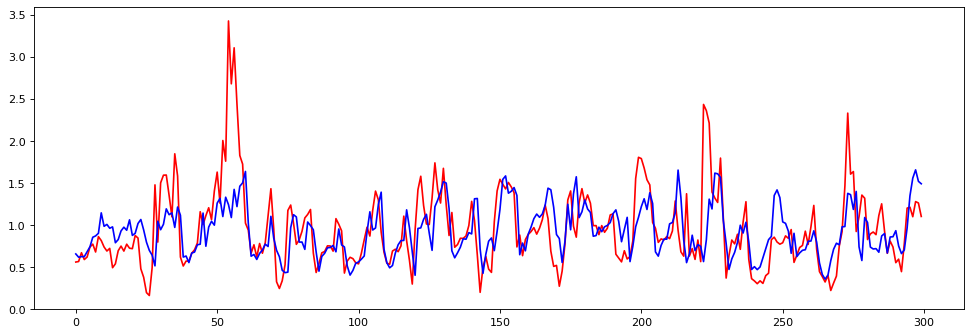

In [412]:
y_test = st_y.inverse_transform(y_test)
y_pred = st_y.inverse_transform(y_pred)

plt.figure(figsize=(15, 5), dpi=80)
plt.plot(range(len(x_test)), y_test, color='red')
plt.plot(range(len(x_test)), y_pred, color='blue')

In [361]:

mean_absolute_percentage_error(y_test, y_pred)

0.32038267909987117